In [1]:
# for visualization
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# for modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

- <b>Employee ID</b> : The unique ID allocated for each employee (example: fffe390032003000)
- <b>Date of Joining:</b> The date-time when the employee has joined the organization (example: 2008-12-30)
- <b>Gender</b>: The gender of the employee (Male/Female)
- </b>Company Type</b>: The type of company where the employee is working (Service/Product)
- <b>WFH Setup Available</b>: Is the work from home facility available for the employee (Yes/No)
- <b>Designation</b>: The designation of the employee of work in the organization. In the range of [0.0, 5.0] bigger is higher designation.
- <b>Resource Allocation</b>: The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource)
- <b>Mental Fatigue Score</b>: The level of fatigue mentally the employee is facing. In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
- <b>Burn Rate</b>: The value we need to predict for each employee telling the rate of Bur out while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [2]:
# Read Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


Employee ID does not matter in our analysis. We should change 'Date of Joining' column to a proper datatype format so we can use it in our analysis. We have 3 categorical columns and 3 float columns. 

In [5]:
# description of data
train.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [6]:
# Percentage of missing data from each column
pd.DataFrame(round(train.isna().sum() / len(train) * 100, 2)).T

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0.0,0.0,0.0,0.0,0.0,0.0,6.07,9.31,4.94


We only have missing data from two feautures and from our target 'Burn Rate'. We can look into how we can choose to impute data for our two features. We can also look into dropping the rows where 'Burn Rate' data is missing since it's only 5%.

In [7]:
# change Date of joining to correct datatype
train['Date of Joining'] = pd.to_datetime(train['Date of Joining'], format = '%Y-%m-%d')
test['Date of Joining'] = pd.to_datetime(test['Date of Joining'], format = '%Y-%m-%d')

In [8]:
# Range of dates for train data
print(min(train['Date of Joining']))
print(max(train['Date of Joining']))

2008-01-01 00:00:00
2008-12-31 00:00:00


In [9]:
# Range of dates for test data
print(min(test['Date of Joining']))
print(max(test['Date of Joining']))

2008-01-01 00:00:00
2008-12-31 00:00:00


It appears that both train and test datasets only contain data from 2008. Assuming that this data was collected on the last day shown we can count how many days they've worked based on Date of Joining. 

Since we have proper datatype for 'date of joining' and we can assume that 2008-12-31 is when this data was collected we can count how many days each employee has been working for the company.

In [10]:
days_worked = max(train['Date of Joining']) - train['Date of Joining']
days_worked = days_worked.dt.days
train.insert(2,'Days_Worked', days_worked)

In [11]:
train.head()

,Employee ID,Date of Joining,Days_Worked,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,92,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,31,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,296,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,58,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,160,Female,Service,No,3.0,7.0,6.9,0.52


In [12]:
train.dtypes

Employee ID                     object
Date of Joining         datetime64[ns]
Days_Worked                      int64
Gender                          object
Company Type                    object
WFH Setup Available             object
Designation                    float64
Resource Allocation            float64
Mental Fatigue Score           float64
Burn Rate                      float64
dtype: object

### Exploratory Analysis

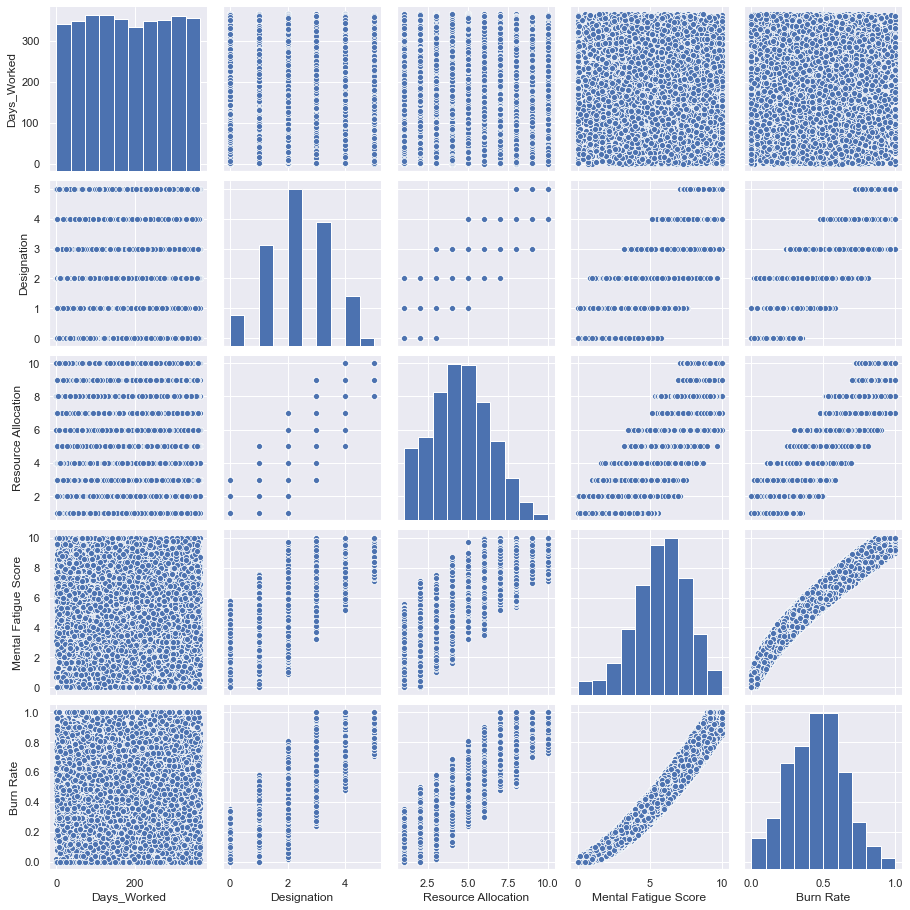

In [13]:
# pair plot
sns.pairplot(train)

As we can from the graph above burn rate has a positive relationship with every feature except Days_Wroked. We can also see that the variables have a positive relationship with each other. From the histograms for each feature we can see that 'Mental Fatigue Score' & 'Resource Allocaion' are normally distributed so we can take that into consideration when imputing our data for those columns.

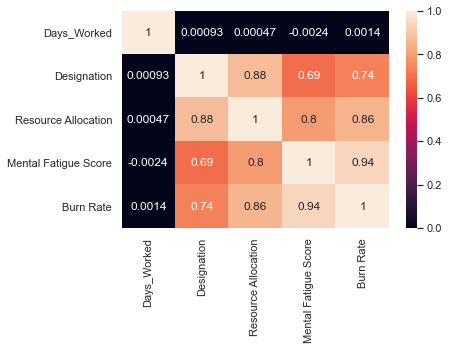

In [14]:
# heat map correlation
corr = train.corr()
sns.heatmap(corr, annot = True)

Mental Fatigue Score has the highest correlation with Burn Rate, but our other scores for the other two variables are still high. Days_worked apparently has no correlation with Burn Rate.

Text(0.5, 1.0, 'Average Burn Rate by Date of Joining')

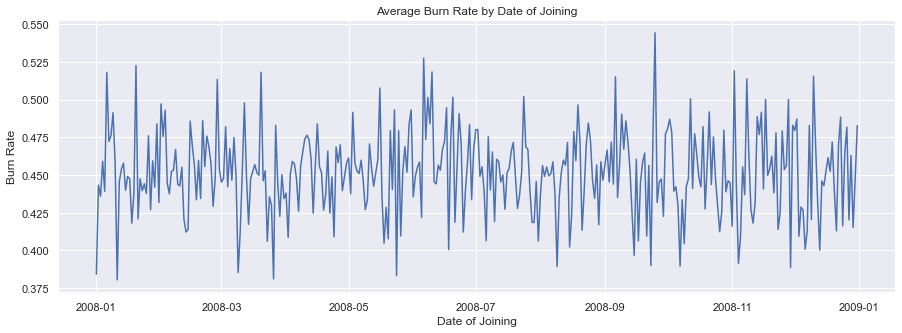

In [15]:
# graph mean by date
plt.figure(figsize=(15,5))
mean_by_date = train.groupby('Date of Joining')['Burn Rate'].mean().to_frame().reset_index()
sns.lineplot(x= 'Date of Joining', y = 'Burn Rate', data = mean_by_date)
plt.title('Average Burn Rate by Date of Joining')

Plotting 'Date of Joining' with average 'Burn Rate' for each day shows no apparent connection.

### Categorical Variables

Questions we would like to know about categorical variables:
1. Count of each categroical variable.
2. Relationship of Categorical Variables with Burn Rate.

### Counts

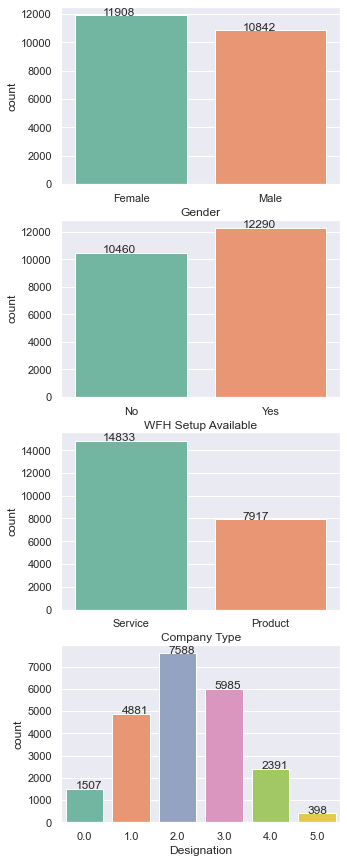

In [30]:
fig, axes = plt.subplots(4,1, figsize=(5,15))

sns.set_palette(sns.color_palette('Set2'))
cats = ['Gender', 'WFH Setup Available', 'Company Type', 'Designation']

for cat, ax in zip(cats, axes):
    #plt.figure()
    g = sns.countplot(x= cat, data=train, ax = ax)
    
    for p in ax.patches:
        g.text(p.get_x()+.2, p.get_height() + 1, '{:1.0f}'.format(p.get_height()))

### Boxplots

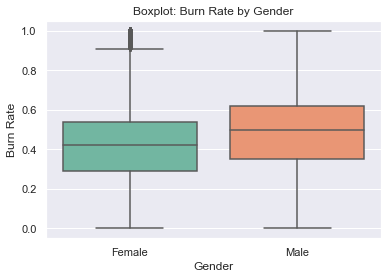

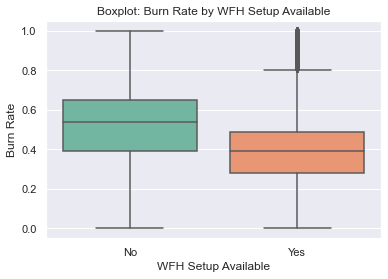

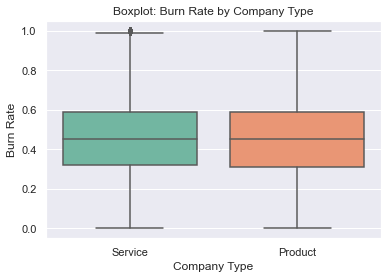

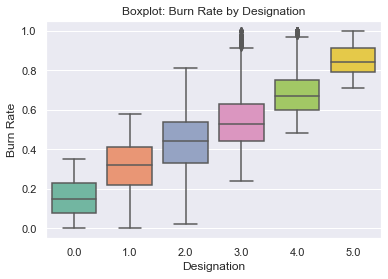

In [31]:
# Boxplot for categorical variables
for cat in cats:
    plt.figure()
    sns.boxplot(x = cat, y = 'Burn Rate', data = train)
    plt.title('Boxplot: Burn Rate by ' + str(cat))

- The average 'Burn Rate' for males is slightly higher for males than it is for females.
- The average 'Burn Rate' for people that don't have WFH setup is higher than for it's counterpart.
- The 'Burn Rate' seems to be distributed almost equally for both company types. So this variable may not affect 'Burn Rate'.
- We know that as Designation increases so does average Burn Rate.

### Interactions

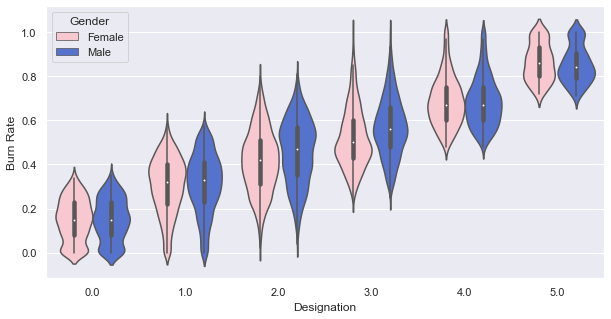

In [43]:
plt.figure(figsize = (10,5))
g = sns.violinplot(data=train, x = 'Designation', y = 'Burn Rate', hue = 'Gender',
               palette = sns.color_palette(['pink', 'royalblue']))

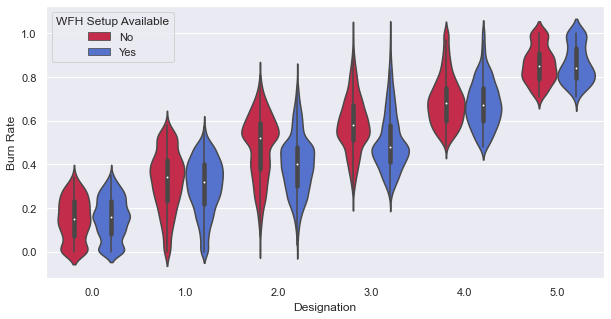

In [44]:
plt.figure(figsize = (10,5))
g = sns.violinplot(data=train, x = 'Designation', y = 'Burn Rate', hue = 'WFH Setup Available',
               palette = sns.color_palette(['crimson', 'royalblue']))

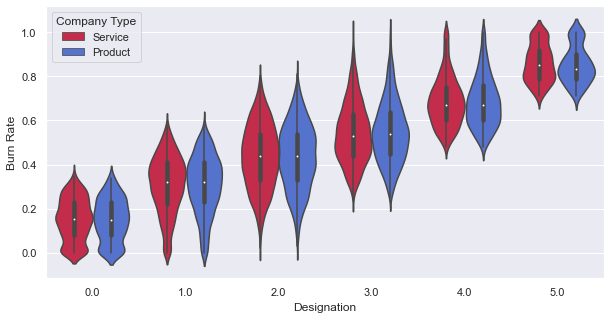

In [45]:
plt.figure(figsize = (10,5))
g = sns.violinplot(data=train, x = 'Designation', y = 'Burn Rate', hue = 'Company Type',
               palette = sns.color_palette(['crimson', 'royalblue']))

From our interactions we found that:
- Burn rates for genders are similar for every designation.
- Burn rates for workers who don't have WFH are larger than those who don't at designations 2, 3. Other designations have similar Burn Rate distribtutions regardless of WFH availability.
- Company type has no affect on Burn Rates in any designation.

### In Conclusion
From our analysis we can see that the variables Designation, Resource Allocation, and Mental Fatigue have a strong linear relationship with our target variable Burn Rate. Mental Fatigue seems to have the strongest relationship. From our categorical variables it seems that none have a significant affect on Burn Rate.

### Pre-Processing

In [46]:
# gender to dummy variable
is_male = pd.get_dummies(train['Gender'], drop_first =True)
train.insert(3, 'is_male', is_male)

In [47]:
# Company type to dummy variable
is_service = pd.get_dummies(train['Company Type'], drop_first = True)
train.insert(5, 'is_service', is_service)

In [48]:
# Company type to dummy variable
is_wfh = pd.get_dummies(train['WFH Setup Available'], drop_first = True)
train.insert(7, 'is_wfh', is_wfh)

In [49]:
train.head()

,Employee ID,Date of Joining,Days_Worked,is_male,Gender,is_service,Company Type,is_wfh,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,92,0,Female,1,Service,0,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,31,1,Male,1,Service,1,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,296,0,Female,0,Product,1,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,58,1,Male,1,Service,1,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,160,0,Female,1,Service,0,No,3.0,7.0,6.9,0.52


In [50]:
# drop useless columns we don't need
columns = ['Employee ID', 'Date of Joining', 'Gender', 'Company Type', 'WFH Setup Available','Days_Worked']
df1 = train.drop(columns = columns)

Decided to also drop Days_Worked because it didn't seem to have any relation to 'Burn Rate'.

In [51]:
df1.head()

,is_male,is_service,is_wfh,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,1,0,2.0,3.0,3.8,0.16
1,1,1,1,1.0,2.0,5.0,0.36
2,0,0,1,2.0,NaN,5.8,0.49
3,1,1,1,1.0,1.0,2.6,0.20
4,0,1,0,3.0,7.0,6.9,0.52


In [52]:
# Want to remove rows that don't have target 
df1.isna().sum()

is_male                    0
is_service                 0
is_wfh                     0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [53]:
# Take care of missing data in Burn Rate
# drop NA rows target, 1124 rows
df1.dropna(subset=['Burn Rate'], inplace=True)

In [54]:
# will handle missing values in Resource Alloc & Mental Fatigue with imputes
df1.isna().sum()

is_male                    0
is_service                 0
is_wfh                     0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
dtype: int64

In [55]:
df1.head()

,is_male,is_service,is_wfh,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,1,0,2.0,3.0,3.8,0.16
1,1,1,1,1.0,2.0,5.0,0.36
2,0,0,1,2.0,NaN,5.8,0.49
3,1,1,1,1.0,1.0,2.6,0.20
4,0,1,0,3.0,7.0,6.9,0.52


In [56]:
# seperate X and y
X = df1.iloc[:,:-1].values
y = df1.iloc[:,-1].values

In [57]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
# impute values for X_train and X_test
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_train = imp_mean.fit_transform(X_train)
X_val = imp_mean.fit_transform(X_val)

In [59]:
X_train

array([[0. , 1. , 0. , 2. , 3. , 6.8],
       [1. , 1. , 0. , 2. , 3. , 5.3],
       [0. , 1. , 1. , 1. , 2. , 4.3],
       ...,
       [1. , 1. , 0. , 3. , 7. , 8.5],
       [0. , 0. , 1. , 1. , 3. , 5.1],
       [1. , 1. , 1. , 1. , 2. , 5.8]])

In [60]:
X_val

array([[0.        , 0.        , 0.        , 3.        , 4.49479269,
        6.        ],
       [0.        , 1.        , 0.        , 2.        , 4.49479269,
        6.7       ],
       [1.        , 1.        , 1.        , 0.        , 1.        ,
        1.3       ],
       ...,
       [1.        , 1.        , 1.        , 4.        , 4.49479269,
        8.5       ],
       [0.        , 1.        , 1.        , 3.        , 5.        ,
        5.73871295],
       [0.        , 1.        , 0.        , 2.        , 4.49479269,
        6.8       ]])

In [61]:
# scale X 
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.fit_transform(X_val)

In [62]:
X_train_sc

array([[-0.95637335,  0.727382  , -1.08491796, -0.15641157, -0.74347187,
         0.58186444],
       [ 1.04561676,  0.727382  , -1.08491796, -0.15641157, -0.74347187,
        -0.23147134],
       [-0.95637335,  0.727382  ,  0.92172868, -1.03390698, -1.24575812,
        -0.77369519],
       ...,
       [ 1.04561676,  0.727382  , -1.08491796,  0.72108384,  1.26567314,
         1.50364498],
       [-0.95637335, -1.37479345,  0.92172868, -1.03390698, -0.74347187,
        -0.33991611],
       [ 1.04561676,  0.727382  ,  0.92172868, -1.03390698, -1.24575812,
         0.03964059]])

In [63]:
X_val_sc

array([[-9.37408786e-01, -1.36412850e+00, -1.08194926e+00,
         7.30100596e-01, -4.49951384e-16,  1.45479423e-01],
       [-9.37408786e-01,  7.33068770e-01, -1.08194926e+00,
        -1.60615542e-01, -4.49951384e-16,  5.35225476e-01],
       [ 1.06677046e+00,  7.33068770e-01,  9.24257757e-01,
        -1.94204782e+00, -1.77046275e+00, -2.47138693e+00],
       ...,
       [ 1.06677046e+00,  7.33068770e-01,  9.24257757e-01,
         1.62081673e+00, -4.49951384e-16,  1.53742961e+00],
       [-9.37408786e-01,  7.33068770e-01,  9.24257757e-01,
         7.30100596e-01,  2.55938135e-01, -3.16492831e-14],
       [-9.37408786e-01,  7.33068770e-01, -1.08194926e+00,
        -1.60615542e-01, -4.49951384e-16,  5.90903484e-01]])

### Random Forest Regression

In [64]:
# SIMPLE random forest regressor, baseline
RFR = RandomForestRegressor(n_estimators=10, random_state=42)

In [65]:
RFR.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [66]:
# mean score of cross_validaiton
np.mean(cross_val_score(RFR, X_train_sc, y_train, cv = 10, scoring = 'r2'))

0.8903661104933465

Lets see if we can increase this score by hyperparameter tuning.  

In [67]:
# hyperparameters to tune

# Ntrees in random forest
n_estimators = [10, 50, 100, 200, 300, 400, 500, 750, 800, 1000]

# max features to consider at splits
max_features = ['auto', 'sqrt']

# max levels in tree
max_depth = [5, 8, 15, 25, 30, None]

# min number of samples required to split
min_samples_split = [2, 5, 10, 15, 100]

# min number of samples required in each leaf
min_samples_leaf = [1,2,4]

# Method of selecting samples
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [68]:
random_grid

{'n_estimators': [10, 50, 100, 200, 300, 400, 500, 750, 800, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 8, 15, 25, 30, None],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [69]:
# now to use RandomizedSearchCv to search for best hyperparamters
rf = RandomForestRegressor()

# search 100 combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions =  random_grid, n_iter = 100, cv = 3, verbose = 2,
                              random_state=42, n_jobs = -1)

# fit random search model
rf_random.fit(X_train_sc, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         400, 500, 750, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [70]:
# best parameters 
best_params = rf_random.best_params_
print(best_params)

{'n_estimators': 800, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 25, 'bootstrap': True}


In [71]:
# best model
RFR_best = rf_random.best_estimator_

# predict on this 
y_pred = RFR_best.predict(X_val_sc)
metrics.r2_score(y_val, y_pred)

0.908228470882041

Using RandomGridSearchCV we found a Random Forest that gives us a 90.82% R^2 on the validation set. Lets see if we can increase that by using GridSearchCv but using parameters that were close to that those parameters.

In [72]:
param_grid = {
    'bootstrap':[True],
    'n_estimators': [600, 750,800, 850],
    'max_depth': [20,22,25,28],
    'min_samples_split': [95,100,105],
    'min_samples_leaf': [1,2,3]
}

In [73]:
# grid search with new params
RF_search = RandomForestRegressor()
grid_search = GridSearchCV(estimator = RF_search, param_grid = param_grid, cv=3, n_jobs = -1, verbose = 2)

In [74]:
grid_search.fit(X_train_sc, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 17.5min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 22, 25, 28],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [95, 100, 105],
                         'n_estimators': [600, 750, 800, 850]},
             verbose=2)

In [75]:
# best params with gridsearch
print(grid_search.best_params_)
search_best_model = grid_search.best_estimator_

{'bootstrap': True, 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 95, 'n_estimators': 750}


In [76]:
# prediction on val set
y_pred = search_best_model.predict(X_val_sc)
metrics.r2_score(y_val, y_pred)

0.9083543004278141

Our GridSearchCv only slightly increaesed our R^2 on our validation set.

Text(0.5, 1.0, 'Feature Importance for Random Forest Regression')

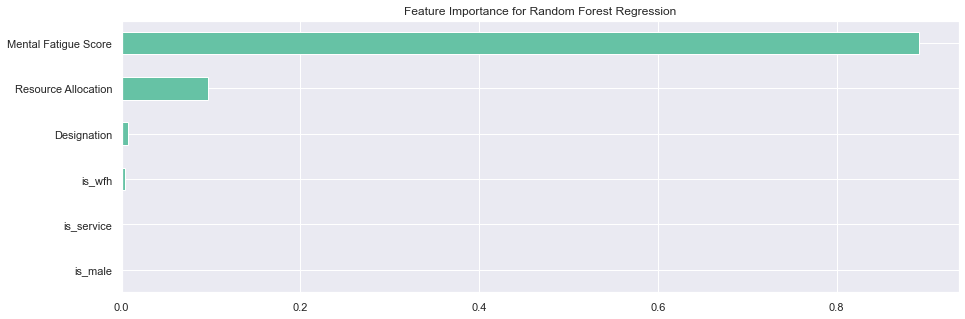

In [79]:
# plot feature importance in our model
plt.figure(figsize=(15,5))
labels = df1.iloc[:,:-1].columns
importances = search_best_model.feature_importances_

(pd.Series(importances, index=labels)).plot(kind='barh')
plt.title('Feature Importance for Random Forest Regression')

Looking at our Feature Importance graph we can see that Mental Fatigue Score was largely the most significant variable followed by Resource Allocation in our Model. Designation and WFH availability had some importance, but almost insignifcant. As we had seen from our EDA Gender and Service type had NO significance whatsoever to our model.

### Support Vector Regression

In [80]:
# base line for SVR, parameters
SVReg = SVR()
SVReg.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [81]:
# Baseline r2 with default SVR parameters
np.mean(cross_val_score(SVReg, X_train_sc, y_train, cv = 10, scoring = 'r2'))

0.8899605362918146

In [82]:
# kernels
kernels = ['rbf', 'linear']

#gammas
gammas = [0.001, 0.01, 0.1, 1, 10]

# C's 
Cs = [0.001, 0.01, 0.1, 1, 10]

# es
param_grid = {
    'kernel': kernels,
    'gamma' : gammas,
    'C': Cs
}

In [83]:
# grid search cv search for parameters
grid_search = GridSearchCV(SVReg, param_grid, cv = 3, verbose=2, n_jobs = -1)

grid_search.fit(X_train_sc, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.9min finished


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [84]:
# best parameters
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [87]:
# SVR best model
SVR_best = grid_search.best_estimator_

In [91]:
# cross val SVR model on training data, slightly better
np.mean(cross_val_score(SVR_best, X_train_sc, y_train, cv = 10, scoring = 'r2'))

0.8901532348762433

In [90]:
# predicition and score on valdiation set.
y_pred = SVR_best.predict(X_val_sc)
metrics.r2_score(y_val, y_pred)

0.8837071150465046

Our Random Regression model had a better r2 score.

## Final Words
When I first looked at the dataset I assumed that Date of Joining would have a significant affect on Burn Rate amongst workers, but that proved to be false. I plotted average Burn Rate by date and found no relationship. During our analysis we also found that Mental Fatigue was the leading predictive variable for  Burn Rate which makes alot of sense. The next significant variable was Resource Allocation. There were two variables that only slightly influenced Burn Rate which were Designation and WFH availability. We also found that Gender and Company type had no significance in predicting Burn Rate.